# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/My Drive/fall 2025/CSC 474/Project/Dataset/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019.csv'

df = pd.read_csv(path, nrows=2500000)

In [ ]:
df.columns

Index(['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence',
       'Violation Status', 'Violation Type', 'Bus Route ID',
       'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name',
       'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference',
       'Bus Stop Georeference'],
      dtype='object')

In [ ]:
df['First Occurrence'].min()

'01/01/2025 01:00:01 PM'

# Parse and Clean Dataset

In [ ]:
df['First Occurrence'] = pd.to_datetime(df['First Occurrence'], errors='coerce', utc=True)

In [ ]:
time_local = df['First Occurrence'].dt.tz_convert('America/New_York')
df['Month'] = (time_local.dt.tz_localize(None).dt.to_period('M').dt.to_timestamp())
df['Day'] = time_local.dt.floor('D')

In [ ]:
df['Bus Route ID'].unique()

array(['M15+', 'M86+', 'Q58', 'B46+', 'M101', 'M60+', 'B42', 'M14+',
       'M34+', 'M23+', 'B44+', 'BX41+', 'BX35', 'B41', 'Q69', 'B25',
       'B35', 'B82+', 'BX12+', 'BX36', 'BX19', 'M79+', 'M96', 'BX28-BX38',
       'BX6+', 'Q44+', 'BX3', 'Q5', 'Q53+', 'S46', 'Q54', 'M100', 'BX28',
       'BX38', 'Q6', 'B62', 'B26', 'Q43', 'BX7', 'BX20', 'M116', 'Q17',
       'BX22', 'M42', 'M2', 'S79+', 'BX6', 'M4', 'BX2', 'BX5', 'Q44?+'],
      dtype=object)

# Get GeoData of Violations

In [ ]:
import geopandas as gpd

In [ ]:
df['Violation Latitude'] = df['Violation Latitude'].astype(float)
df['Violation Longitude'] = df['Violation Longitude'].astype(float)

violations_geo = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Violation Longitude'], df['Violation Latitude']), crs=4326
)

In [ ]:
violations_geo.head()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference,Month,Day,geometry
0,504664883,20d2b83258847859f5274a0c3c0115642253454ba03a37...,2025-11-05 07:59:41+00:00,11/05/2025 08:05:41 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.736261,-73.981960,401779.0,2 AV/E 23 ST,40.737516,-73.981202,POINT (-73.98196 40.736261),POINT (-73.981202 40.737516),2025-11-01,2025-11-05 00:00:00-05:00,POINT (-73.98196 40.73626)
1,504664880,7e3e5ef63c5fd3491a0d2e5661ffc5213d107d040b1c9a...,2025-11-06 21:17:36+00:00,11/06/2025 09:23:31 PM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS LANE,M15+,40.737651,-73.977964,405322.0,1 AV/E 15 ST,40.732139,-73.981946,POINT (-73.977964 40.737651),POINT (-73.981946 40.732139),2025-11-01,2025-11-06 00:00:00-05:00,POINT (-73.97796 40.73765)
2,504592898,8c62d032fb3cd620d3023b51844d50ef4528d6b5caa749...,2025-11-05 12:58:21+00:00,11/05/2025 01:16:07 PM,EXEMPT - COMMERCIAL UNDER 20,MOBILE DOUBLE PARKED,M86+,40.785892,-73.970755,401927.0,W 86 ST/CENTRAL PK WEST,40.785700,-73.970102,POINT (-73.970755 40.785892),POINT (-73.970102 40.7857),2025-11-01,2025-11-05 00:00:00-05:00,POINT (-73.97076 40.78589)
3,504562790,c4d4c5be76fcc1b68e439d52d499f0b5725f5b16fafe52...,2025-10-31 10:45:31+00:00,10/31/2025 10:50:18 AM,EXEMPT - OTHER,MOBILE DOUBLE PARKED,Q58,40.739855,-73.853172,701029.0,108 ST/OTIS AV,40.740850,-73.853759,POINT (-73.853172 40.739855),POINT (-73.853759 40.74085),2025-10-01,2025-10-31 00:00:00-04:00,POINT (-73.85317 40.73986)
4,504481646,7db7231e1642a97e954e02506cc2128e91904f0d8c0a5c...,2025-11-05 11:27:42+00:00,11/05/2025 11:54:37 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,B46+,40.662108,-73.931451,303612.0,UTICA AV/WINTHROP ST,40.658140,-73.930984,POINT (-73.931451 40.662108),POINT (-73.930984 40.65814),2025-11-01,2025-11-05 00:00:00-05:00,POINT (-73.93145 40.66211)


In [ ]:
violations_geo = violations_geo.set_geometry("geometry")

# Organize Area GeoData

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString

feet_per_meter = 3.28084

In [ ]:
areas = [
  ('Lower Manhattan / FiDi', 40.7075, -74.0113),
  ('Soho / Greenwich Village', 40.7280, -74.0000),
  ('Lower East Side', 40.7150, -73.9860),
  ('Midtown', 40.7549, -73.9840),
  ('Upper East Side', 40.7736, -73.9566),
  ('Upper West Side', 40.7870, -73.9754),
  ('Harlem', 40.8116, -73.9465),
  ('Downtown Brooklyn', 40.6925, -73.9905),
  ('Williamsburg', 40.7081, -73.9571),
  ('Bushwick', 40.6943, -73.9213),
  ('Bed-Stuy', 40.6872, -73.9418),
  ('Crown Heights', 40.6681, -73.9448),
  ('Flatbush', 40.6409, -73.9598),
  ('Bay Ridge', 40.6350, -74.0230),
  ('Coney Island', 40.5755, -73.9707),
  ('Sunnyside', 40.7451, -73.9196),
  ('Jackson Heights', 40.7557, -73.8852),
  ('Flushing', 40.7675, -73.8331),
  ('Forest Hills', 40.7187, -73.8448),
  ('Jamaica Center', 40.7027, -73.7993),
  ('Far Rockaway', 40.6054, -73.7550),
  ('South Bronx', 40.8160, -73.9070),
  ('Mott Haven', 40.8090, -73.9220),
  ('Fordham', 40.8614, -73.8903),
  ('Riverdale', 40.9030, -73.9140),
  ('Pelham Parkway', 40.8575, -73.8590),
  ('Staten Island North Shore', 40.6411, -74.0875),
  ('St. George', 40.6438, -74.0740),
  ('Mid-Island / New Dorp', 40.5735, -74.1172),
  ('Elmhurst', 40.7365, -73.8780),
  ('Astoria', 40.7644, -73.9235),
  ('Maspeth', 40.7239, -73.9120),
  ('Bushwick', 40.6943, -73.9213),
  ('Flatbush', 40.6409, -73.9598),
  ('Bayside', 40.7660, -73.7803),
  ('DUMBO', 40.7033, -73.9881),
  ('Coney Island', 40.5755, -73.9707),
  ('Howard Beach', 40.6573, -73.8448),
  ('Bensonhurst', 40.6115, -73.9970),
  ('Homecrest', 40.5932, -73.9597),
  ('Hunts Point', 40.8121, -73.8831),
  ('Rossville', 40.5517, -74.2153),
  ('Great Kills', 40.5521, -74.1516),
  ('Cypress Hills', 40.6898, -73.8718)
]

areas_geo = gpd.GeoDataFrame(
  areas,
  columns=['area', 'lat', 'lon'],
  geometry=gpd.points_from_xy([a[2] for a in areas], [a[1] for a in areas]),
  crs='EPSG:4326'
)

areas_geo['buffer'] = (areas_geo.to_crs(2263).buffer(1000 * feet_per_meter).to_crs(4326))

# Join Area + Violations

## Quarterly Data (Dashboard 1)

In [ ]:
violations_gdf = gpd.GeoDataFrame(
  violations_geo,
  geometry=gpd.points_from_xy(
      violations_geo['Violation Longitude'],
      violations_geo['Violation Latitude']
  ),
  crs='EPSG:4326'
)

viol_join = gpd.sjoin(violations_gdf, areas_geo.set_geometry('buffer'), how='left', predicate='within')

In [ ]:
viol_join['Quarter'] = viol_join['Month'].dt.to_period('Q').astype(str)

quarterly = viol_join.groupby(['area', 'Quarter']).size().reset_index(name='violations')

In [ ]:
areas_quarter = quarterly.merge(
  areas_geo[['area', 'buffer']],
  on='area',
  how='left'
)

areas_quarter = gpd.GeoDataFrame(areas_quarter, geometry='buffer', crs='EPSG:4326')

In [ ]:
areas_quarter.head()

,area,Quarter,violations,buffer
0,Astoria,2024Q4,374,"POLYGON ((-73.91166 40.76439, -73.91171 40.763..."
1,Astoria,2025Q1,1203,"POLYGON ((-73.91166 40.76439, -73.91171 40.763..."
2,Astoria,2025Q2,1193,"POLYGON ((-73.91166 40.76439, -73.91171 40.763..."
3,Astoria,2025Q3,1166,"POLYGON ((-73.91166 40.76439, -73.91171 40.763..."
4,Astoria,2025Q4,462,"POLYGON ((-73.91166 40.76439, -73.91171 40.763..."


In [ ]:
len(areas_quarter['area'].unique())

30

In [ ]:
areas_quarter['centroid'] = areas_quarter.geometry.centroid
areas_quarter['lon'] = areas_quarter.centroid.x
areas_quarter['lat'] = areas_quarter.centroid.y

/tmp/ipython-input-224792293.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_quarter['centroid'] = areas_quarter.geometry.centroid
/tmp/ipython-input-224792293.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_quarter['lon'] = areas_quarter.centroid.x
/tmp/ipython-input-224792293.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_quarter['lat'] = areas_quarter.centroid.y


In [ ]:
areas_quarter.drop('centroid', axis=1, inplace=True)
areas_quarter.set_geometry('buffer')

,area,Quarter,violations,buffer,lon,lat
0,Astoria,2024Q4,374,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644
1,Astoria,2025Q1,1203,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644
2,Astoria,2025Q2,1193,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644
3,Astoria,2025Q3,1166,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644
4,Astoria,2025Q4,462,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644
...,...,...,...,...,...,...
152,Williamsburg,2024Q4,1113,"POLYGON ((-73.94527 40.70809, -73.94532 40.707...",-73.9571,40.7081
153,Williamsburg,2025Q1,3368,"POLYGON ((-73.94527 40.70809, -73.94532 40.707...",-73.9571,40.7081
154,Williamsburg,2025Q2,3289,"POLYGON ((-73.94527 40.70809, -73.94532 40.707...",-73.9571,40.7081
155,Williamsburg,2025Q3,3173,"POLYGON ((-73.94527 40.70809, -73.94532 40.707...",-73.9571,40.7081


## Monthly Data (Dashboard 2)

In [ ]:
monthly = viol_join.groupby(['area', 'Month']).size().reset_index(name='violations')

In [ ]:
monthly.head()

,area,Month,violations
0,Astoria,2024-12-01,374
1,Astoria,2025-01-01,421
2,Astoria,2025-02-01,353
3,Astoria,2025-03-01,429
4,Astoria,2025-04-01,401


In [ ]:
monthly['area'].unique()

array(['Astoria', 'Bed-Stuy', 'Bensonhurst', 'Bushwick', 'Crown Heights',
       'DUMBO', 'Downtown Brooklyn', 'Elmhurst', 'Flatbush', 'Flushing',
       'Fordham', 'Harlem', 'Howard Beach', 'Hunts Point',
       'Jamaica Center', 'Lower East Side', 'Lower Manhattan / FiDi',
       'Maspeth', 'Mid-Island / New Dorp', 'Midtown', 'Mott Haven',
       'Pelham Parkway', 'Riverdale', 'Soho / Greenwich Village',
       'South Bronx', 'St. George', 'Staten Island North Shore',
       'Upper East Side', 'Upper West Side', 'Williamsburg'], dtype=object)

In [ ]:
# add borough

area_to_borough = {
  'Astoria': 'Queens',
  'Elmhurst': 'Queens',
  'Flushing': 'Queens',
  'Howard Beach': 'Queens',
  'Jamaica Center': 'Queens',
  'Maspeth': 'Queens',
  'Bed-Stuy': 'Brooklyn',
  'Bensonhurst': 'Brooklyn',
  'Bushwick': 'Brooklyn',
  'Crown Heights': 'Brooklyn',
  'DUMBO': 'Brooklyn',
  'Downtown Brooklyn': 'Brooklyn',
  'Flatbush': 'Brooklyn',
  'Williamsburg': 'Brooklyn',
  'Fordham': 'Bronx',
  'Hunts Point': 'Bronx',
  'Mott Haven': 'Bronx',
  'Pelham Parkway': 'Bronx',
  'Riverdale': 'Bronx',
  'South Bronx': 'Bronx',
  'Harlem': 'Manhattan',
  'Lower East Side': 'Manhattan',
  'Lower Manhattan / FiDi': 'Manhattan',
  'Midtown': 'Manhattan',
  'Soho / Greenwich Village': 'Manhattan',
  'Upper East Side': 'Manhattan',
  'Upper West Side': 'Manhattan',
  'Mid-Island / New Dorp': 'Staten Island',
  'St. George': 'Staten Island',
  'Staten Island North Shore': 'Staten Island'
}


monthly['borough'] = monthly['area'].map(area_to_borough)

## Borough-Wise Data (Dashboard 3)

In [ ]:
areas_quarter['borough'] = areas_quarter['area'].map(area_to_borough)

In [ ]:
borough_totals = areas_quarter.groupby(['borough', 'Quarter'])['violations'].sum().reset_index(name='violations_borough_total')

borough_avgs = borough_totals.copy()
borough_avgs['borough_avg'] = borough_avgs['violations_borough_total'] / \
  areas_quarter.groupby('borough')['area'].nunique().reindex(borough_avgs['borough']).values

merged = areas_quarter.merge(borough_totals, on=['borough', 'Quarter'])
merged = merged.merge(borough_avgs[['borough','Quarter','borough_avg']], on=['borough','Quarter'])

merged['deviation_pct'] = ((merged['violations"' - merged['borough_avg']) / merged['borough_avg'])

In [ ]:
merged.head()

,area,Quarter,violations,buffer,lon,lat,borough,violations_borough_total,borough_avg,deviation_pct
0,Astoria,2024Q4,374,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644,Queens,11378,1896.333333,-0.802777
1,Astoria,2025Q1,1203,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644,Queens,31231,5205.166667,-0.768883
2,Astoria,2025Q2,1193,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644,Queens,33972,5662.000000,-0.789297
3,Astoria,2025Q3,1166,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644,Queens,26386,4397.666667,-0.734859
4,Astoria,2025Q4,462,"POLYGON ((-73.91166 40.76439, -73.91171 40.763...",-73.9235,40.7644,Queens,7359,1226.500000,-0.623318


In [ ]:
merged.drop('buffer', axis=1, inplace=True)
merged.head()

,area,Quarter,violations,lon,lat,borough,violations_borough_total,borough_avg,deviation_pct
0,Astoria,2024Q4,374,-73.9235,40.7644,Queens,11378,1896.333333,-0.802777
1,Astoria,2025Q1,1203,-73.9235,40.7644,Queens,31231,5205.166667,-0.768883
2,Astoria,2025Q2,1193,-73.9235,40.7644,Queens,33972,5662.000000,-0.789297
3,Astoria,2025Q3,1166,-73.9235,40.7644,Queens,26386,4397.666667,-0.734859
4,Astoria,2025Q4,462,-73.9235,40.7644,Queens,7359,1226.500000,-0.623318


## Hourly Violations (Dashboard 4)

In [ ]:
violations_geo['hour'] = violations_geo['First Occurrence'].dt.hour
violations_geo['weekday'] = violations_geo['First Occurrence'].dt.day_name()

time_patterns = violations_geo.groupby(['hour', 'weekday']).size().reset_index()

time_patterns.head()

,hour,weekday,0
0,0,Friday,3581
1,0,Monday,3181
2,0,Saturday,4818
3,0,Sunday,5468
4,0,Thursday,3405


## Violations Type by Area (Dashboard 5)

In [ ]:
viol_type_by_area = (
  viol_join.groupby(['area', 'Violation Type']).size().reset_index(name='count')
)

In [ ]:
pivot_df = viol_type_by_area.pivot_table(
    index='area',
    columns='Violation Type',
    values='count',
    fill_value=0
)


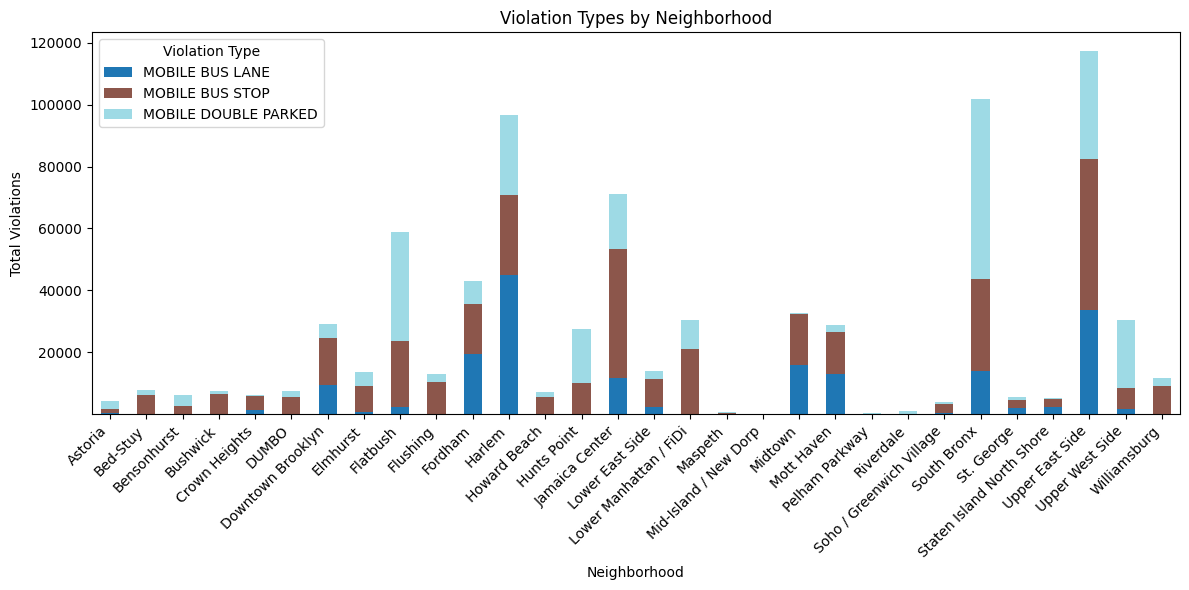

In [ ]:
pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='tab20'
)

plt.title("Violation Types by Neighborhood")
plt.ylabel("Total Violations")
plt.xlabel("Neighborhood")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Export

In [ ]:
monthly.to_csv('nyc_monthly_violations_per_area.csv')

In [ ]:
areas_quarter.to_file("nyc_area_quarter_polygons.geojson", driver="GeoJSON")

In [ ]:
merged.to_csv('nyc_borough_violations.csv')

In [ ]:
time_patterns.to_csv('nyc_violation_time_patterns.csv')